In [1]:
%matplotlib inline

In [2]:
import hcipy as hci
import numpy as np
import matplotlib.pyplot as plt

#from field_max import imshow_fieldv2

In [3]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '../Utils'))
import plot as meplot
sys.path.remove(os.path.join(sys.path[0], '../Utils'))

In [4]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.origin'] = True

## **Parameters**

In [5]:
wvlgth = 1e-6 #666e-9  

diam_aperture = 1.2           
focal_length = 18*diam_aperture 

diam_obs = 0.3/diam_aperture                                 # obscuration ratio
spid_width = 0.05                                            # [m]

print('Wavelength = {} m'.format(wvlgth))
print('Aperture = {} m'.format(diam_aperture))
print('Focal length = {x:.3f} m \n'.format(x=focal_length))
print('Fresnel number = {x:.3f}'.format(x=diam_aperture**2/(wvlgth*focal_length)))

Wavelength = 1e-06 m
Aperture = 1.2 m
Focal length = 21.600 m 

Fresnel number = 66666.667


In [6]:
grid_size_pix = 1024
grid_diam = 1.5*diam_aperture #si on change, baisse pbbly quality

In [7]:
pupil_grid = hci.make_pupil_grid(grid_size_pix, grid_diam)  #It's a computational grid, nothing physical
print('On pupil plane, there is {} m/pix'.format(pupil_grid.delta))  #same as grid_diam/grid_size_pix
print('This is not a real pixel ! This is for the computation\'s sake')

On pupil plane, there is [0.00175953 0.00175953] m/pix
This is not a real pixel ! This is for the computation's sake


## **Aperture Auxtel (spiders + central obscuration)**

In [8]:
central_obs = hci.aperture.make_obstructed_circular_aperture(diam_aperture, diam_obs)
spider_1 = hci.aperture.make_spider([0,0], [0.6,0.6], spid_width)         # [m][m]
spider_2 = hci.aperture.make_spider([0,0], [0.6,-0.6], spid_width)        # [m][m]
spider_3 = hci.aperture.make_spider([0,0], [-0.6,0.6], spid_width)        # [m][m]
spider_4 = hci.aperture.make_spider([0,0], [-0.6,-0.6], spid_width)       # [m][m]

tel_pupil = central_obs(pupil_grid)*spider_1(pupil_grid)*spider_2(pupil_grid)*spider_3(pupil_grid)*spider_4(pupil_grid)

```Python
hci.imshow_field(tel_pupil, cmap='gray')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Aperture')
```

In [9]:
wf = hci.Wavefront(tel_pupil, wvlgth)

## **Sampling**

In [10]:
sampl_focal = 32                            #échantillonage q (8 pix per λ/D) 
fov = 8                                     # [λ/D], radius

focal_grid = hci.make_focal_grid(pupil_grid, sampl_focal, fov)

print('Sampling at focal = {} pixels per λ/D'.format(sampl_focal))
print('Field of view = {} λ/D'.format(fov))

Sampling at focal = 32 pixels per λ/D
Field of view = 8 λ/D


To modelise the sampling, the `focal_grid` is used with `sampl_focal` (8 pixels per λ/D)

---
In POPPY, the equivalent is the `osys.add_detector` with a pixel size `pixsize` (0.1 micron)

In [11]:
pixsize = (wvlgth/diam_aperture)/(sampl_focal*10**-6)
print('There is {} pixels per diffraction width'.format(pixsize))

There is 0.026041666666666668 pixels per diffraction width


## **Atmosphere**

In [12]:
seeing = 1.0 

fried_parameter = 0.2#0.98 * wvlgth/seeing * (180/np.pi) * 3600  # [m]
outer_scale = 20                                             # [m], "L0"

Cn_squared = hci.Cn_squared_from_fried_parameter(fried_parameter, wvlgth)

print('Fried parameter = {} m'.format(fried_parameter))
print('Outer scale L0 = {} m'.format(outer_scale))

Fried parameter = 0.2 m
Outer scale L0 = 20 m


In [13]:
%time
#layer = hci.InfiniteAtmosphericLayer(pupil_grid, Cn_squared)
layer = hci.FiniteAtmosphericLayer(pupil_grid, Cn_squared)

nblayers = 10
layertable = []
for i in range (nblayers):
    layertable.append(hci.FiniteAtmosphericLayer(pupil_grid, Cn_squared))
    i+=1

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [14]:
#layer.evolve_until(500)

## **Propagation**

In [15]:
prop = hci.FraunhoferPropagator(pupil_grid, focal_grid, wvlgth, 10000*focal_length)

In [16]:
foc_img = prop(wf)
foc_img_atm = prop(layer(wf))              # With atmosphere !

/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:81: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[self.cutout_output] = (field.ravel() / self.shift_input).reshape(self.shape_out)
/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:83: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = res[self.cutout_input].ravel() / self.weights / self.shift_output


In [17]:
prop = hci.FraunhoferPropagator(pupil_grid, focal_grid, wvlgth, 10000*focal_length)
foc_img_atmtable = []
for i in range (nblayers):
    foc_img_atmtable.append(prop(layertable[i](wf))) 
    i+=1

## **Plots**

In [18]:
print('1 λ/D = {} arcsec'.format((180/np.pi)*3600 * wvlgth/diam_aperture))

1 λ/D = 0.17188733853924698 arcsec


In [19]:
sumlayers = 0
for i in range (nblayers):
    sumlayers+=foc_img_atmtable[i].intensity
    i+=1
sumlayers/=nblayers

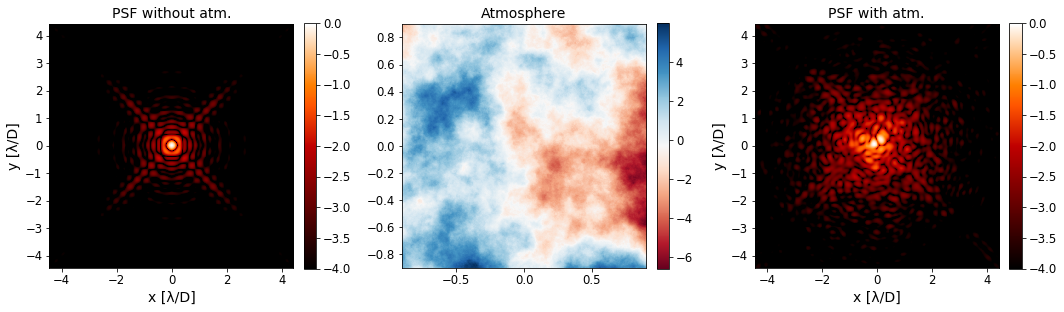

CPU times: user 5 s, sys: 482 µs, total: 5 s
Wall time: 1.44 s


In [32]:
%%time

plt.subplot(1, 3, 1)
hci.imshow_field(np.log10(foc_img.intensity / foc_img.intensity.max()),cmap='gist_heat', vmin=-4)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('PSF without atm.')

plt.subplot(1, 3, 2)
hci.imshow_field(layer.phase_for(wvlgth), cmap='RdBu')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Atmosphere')

plt.subplot(1, 3, 3)
hci.imshow_field(np.log10(foc_img_atm.intensity / foc_img_atm.intensity.max()),cmap='gist_heat', vmin=-4)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('PSF with atm.')

plt.tight_layout()
plt.savefig('HCIPy_atmosphere_1realisation')
plt.show()


## **PSF in 2D (slice or sum)**

In [21]:
map_3 = sumlayers.shaped
xaxis_3 = focal_grid.x.reshape(map_3.shape)[0,:]

In [22]:
map_1 = foc_img.intensity.shaped                         # Take intensity and reshape (1D -> 2D)
map_2 = foc_img_atm.intensity.shaped      

xaxis_1 = focal_grid.x.reshape(map_1.shape)[0,:]
xaxis_2 = focal_grid.x.reshape(map_2.shape)[0,:]

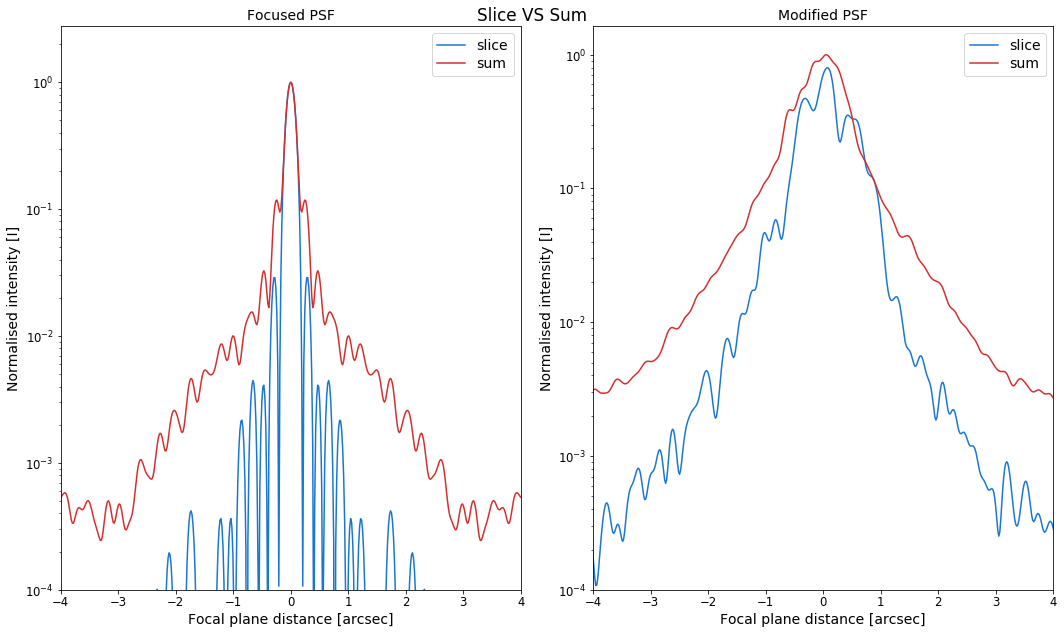

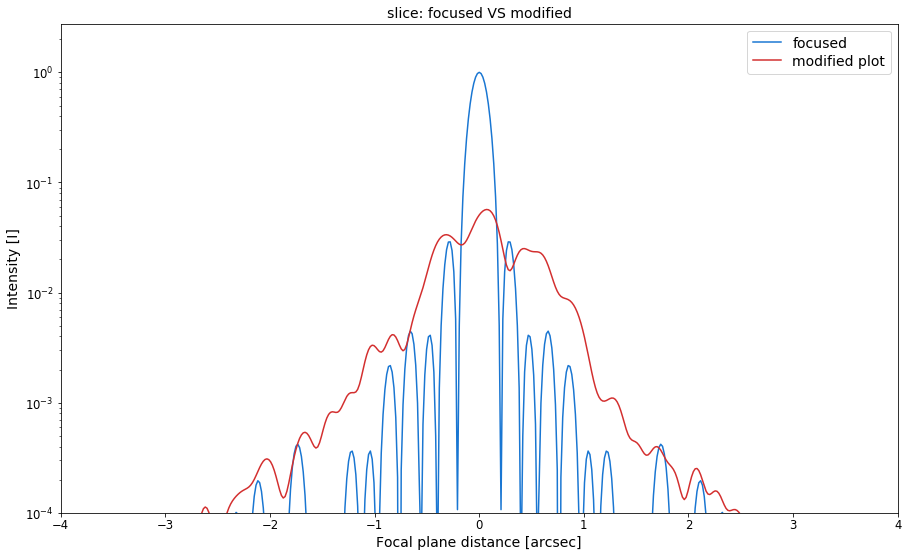

In [24]:
meplot.slicum_for_focdefoc(map_1, map_3, xaxis_1, xaxis_3, 
                           logscale=True, normalised=True, ymin=10**-4, xmin=-4, xmax=4)
plt.savefig('HCIPy_atmosphere_slicum_plots')

meplot.foc_VS_defoc(map_1/map_1.max(), map_3/map_1.max(), xaxis_1, xaxis_3, 
                    logscale=True, normalised=False, wantslice=True, ymin=10**-4, xmin=-4, xmax=4)
plt.savefig('HCIPy_atmosphere_focus_vs_atm')

In [25]:
KIWI ! (to stop the code from running the following)

SyntaxError: invalid syntax (<ipython-input-25-75302b0b60a5>, line 1)

## **Atmosphere**

In [ ]:
%%time
                                                             # cinquantaine de secondes
layers = hci.make_standard_atmospheric_layers(pupil_grid, outer_scale)

atmos = hci.MultiLayerAtmosphere(layers, scintilation=True)

In [ ]:
p = np.exp(-(pupil_grid.as_('polar').r/0.68)**20)
wf = atmos(hci.Wavefront(hci.Field(p, pupil_grid), 2e-6))

hci.imshow_field(wf.intensity)
plt.show()


In [ ]:
pupil_grid3 = hci.make_pupil_grid(256, 1.5)
focal_grid3 = hci.make_focal_grid(pupil_grid3, 2, 64)
prop = hci.FraunhoferPropagator(pupil_grid3, focal_grid3)

pup = hci.circular_aperture(1)(pupil_grid3)

# Make multi-layer atmosphere
layers3 = hci.make_standard_atmospheric_layers(pupil_grid3, outer_scale)

atmos = hci.MultiLayerAtmosphere(layers3, scintilation=True)
# Set the seeing parameters and reset
atmos.Cn_squared = hci.Cn_squared_from_fried_parameter(0.1, 550e-9)
atmos.reset()

# Use super-Gaussian to avoid edge effects
p = np.exp(-(pupil_grid3.as_('polar').r/0.68)**20)
wf3 = atmos(hci.Wavefront(hci.Field(p, pupil_grid3), 2e-6))

# Show scintillation field
hci.imshow_field(wf3.intensity * pup)
plt.show()